In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [22]:
#device setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [23]:
#set up seed for consistancy
torch.manual_seed(1)
#hyperparameters based on slides
learning_rate = 2e-4
batch_size = 128
image_size = 64
#black and white 1 for color img 3(r.g.b)
image_channels = 3
noise_dimension = 100
epochs = 10
discriminator_features = 64
generator_features = 64
adam_beta = 0.5
#get Cifar10 dataset
workers = 2
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ]
)
data_train = torchvision.datasets.CIFAR10(root='./DL HW 3/data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True,num_workers=workers)


Files already downloaded and verified


In [24]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discrim = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._descrimStructure(features_d, features_d * 2, 4, 2, 1),
            self._descrimStructure(features_d * 2, features_d * 4, 4, 2, 1),
            self._descrimStructure(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _descrimStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.discrim(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.genet = nn.Sequential(
            self._genetStructure(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._genetStructure(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._genetStructure(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._genetStructure(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _genetStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.genet(x)

In [25]:
def model_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

Epoch [0/10] Batch 0/391                   Loss D: 0.6972, loss G: 0.7117
Epoch [0/10] Batch 100/391                   Loss D: 0.0733, loss G: 3.5379
Epoch [0/10] Batch 200/391                   Loss D: 0.1969, loss G: 2.6612
Epoch [0/10] Batch 300/391                   Loss D: 0.2283, loss G: 2.5627
Epoch [1/10] Batch 0/391                   Loss D: 0.3131, loss G: 2.3720
Epoch [1/10] Batch 100/391                   Loss D: 0.2686, loss G: 2.0430
Epoch [1/10] Batch 200/391                   Loss D: 0.3367, loss G: 1.8130
Epoch [1/10] Batch 300/391                   Loss D: 0.4496, loss G: 1.5049
Epoch [2/10] Batch 0/391                   Loss D: 0.5875, loss G: 1.7384
Epoch [2/10] Batch 100/391                   Loss D: 0.5161, loss G: 1.1561
Epoch [2/10] Batch 200/391                   Loss D: 0.5195, loss G: 1.1651
Epoch [2/10] Batch 300/391                   Loss D: 0.4396, loss G: 1.4738
Epoch [3/10] Batch 0/391                   Loss D: 0.6352, loss G: 1.4857
Epoch [3/10] Batch 1

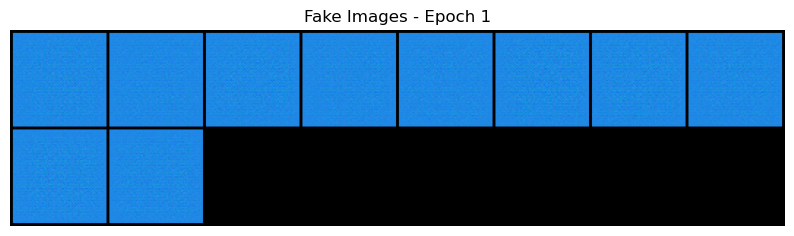

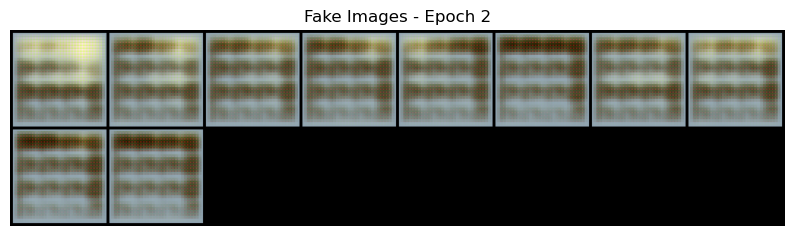

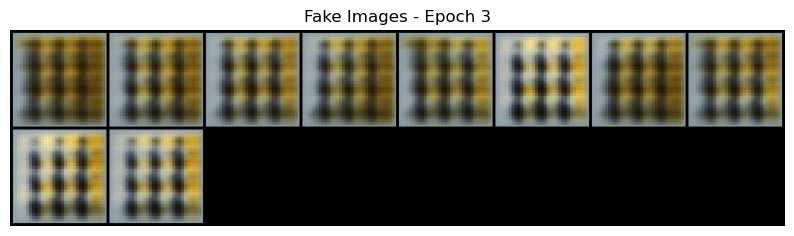

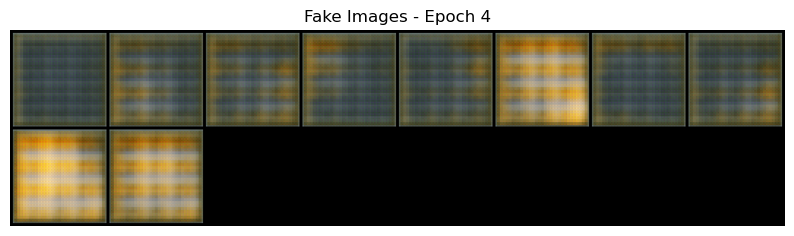

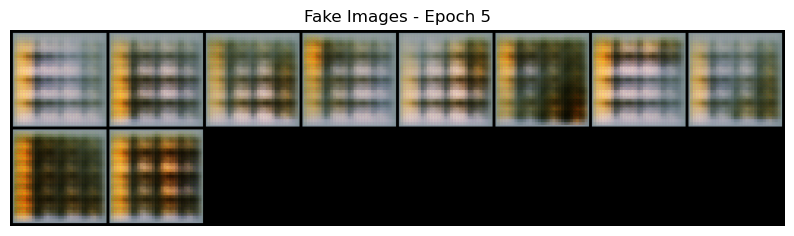

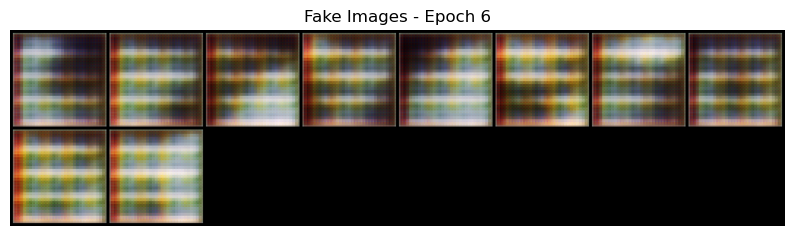

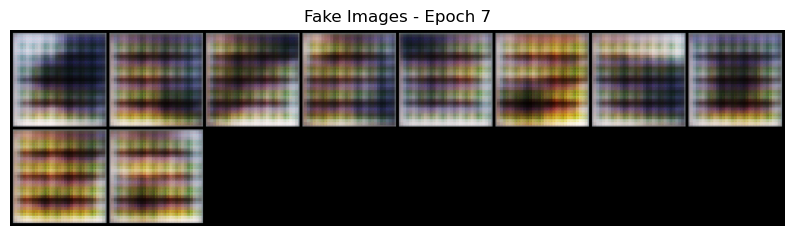

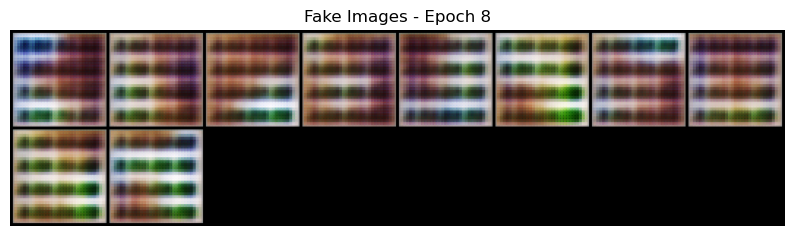

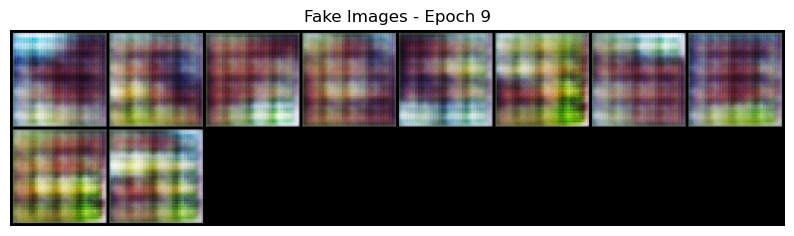

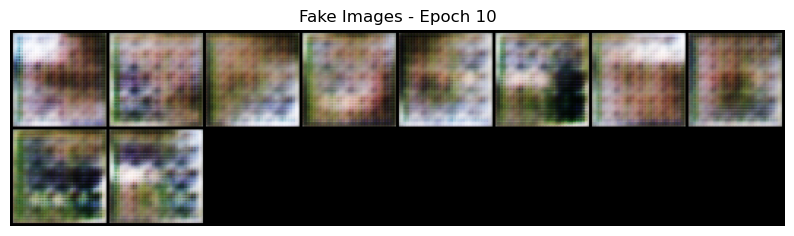

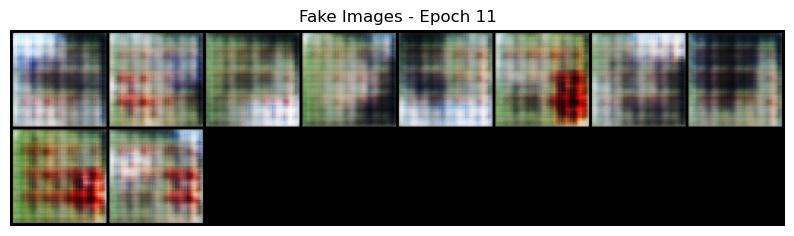

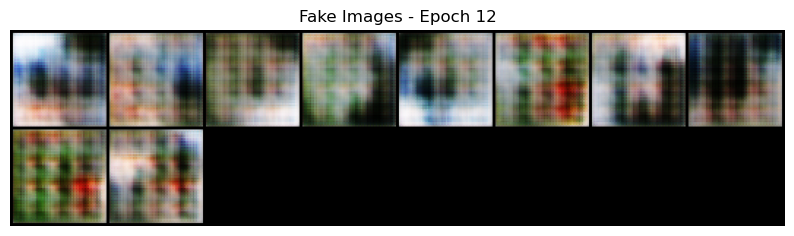

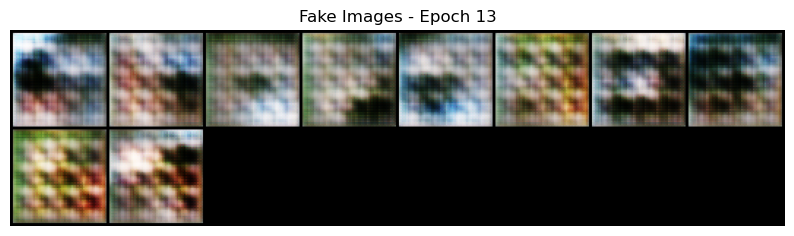

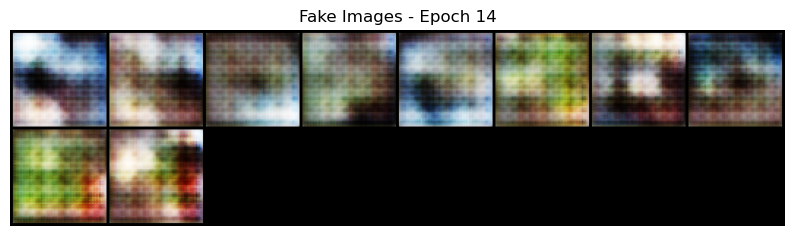

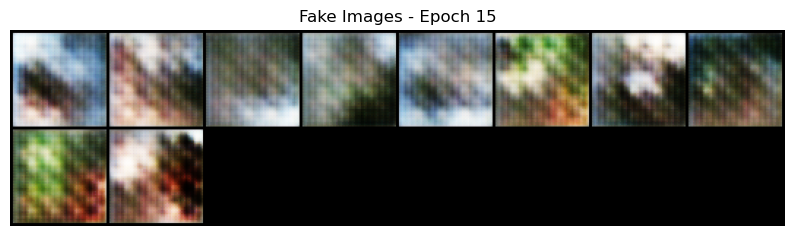

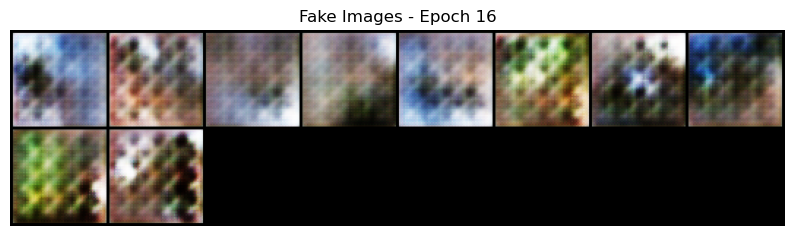

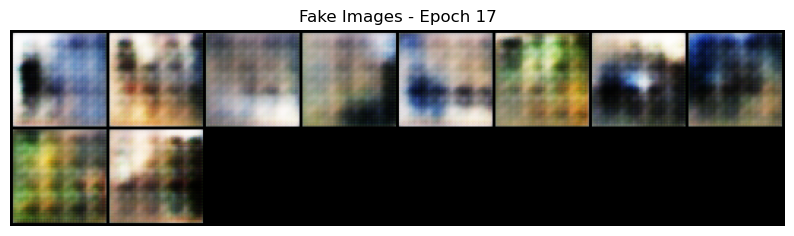

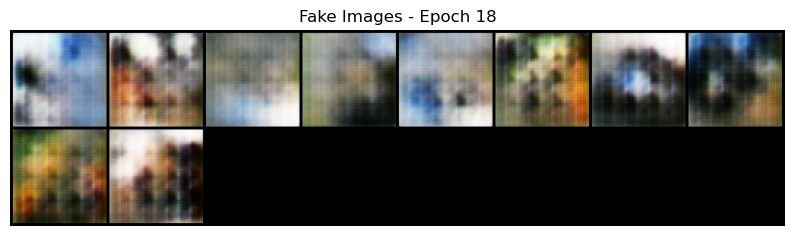

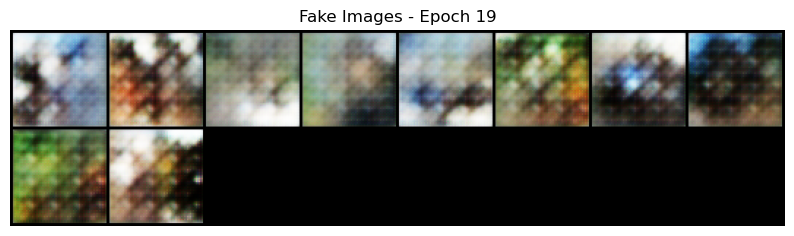

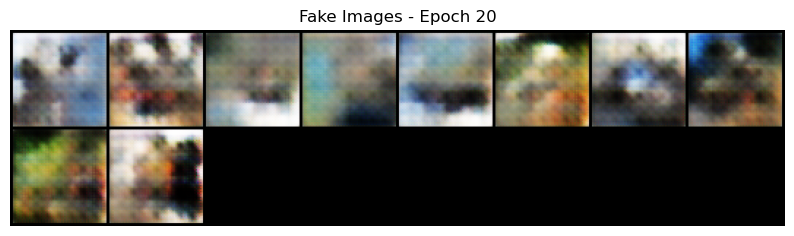

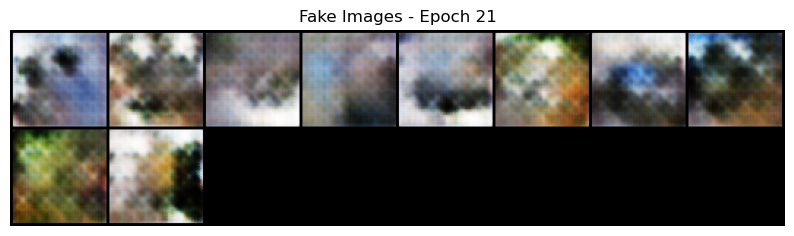

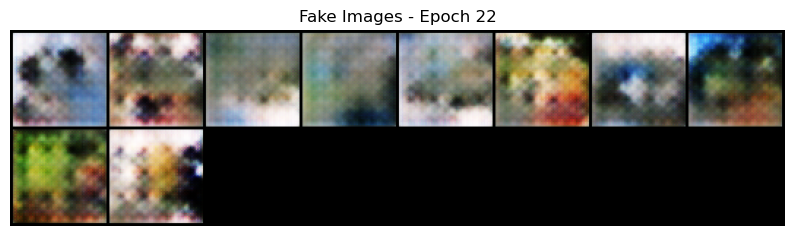

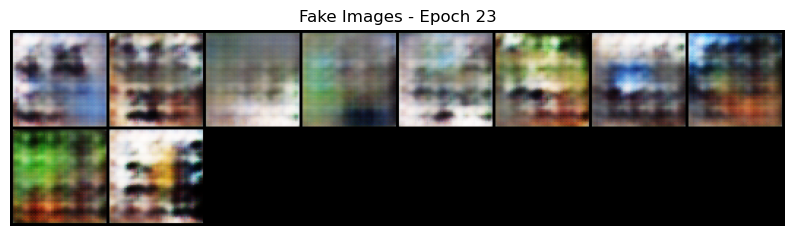

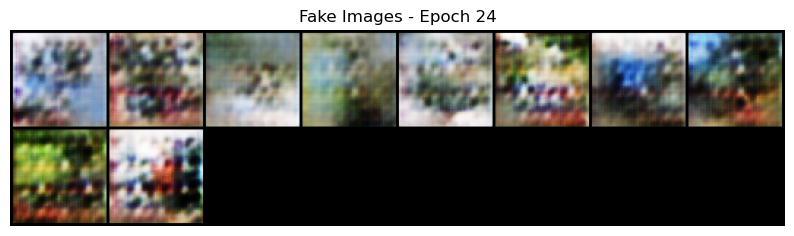

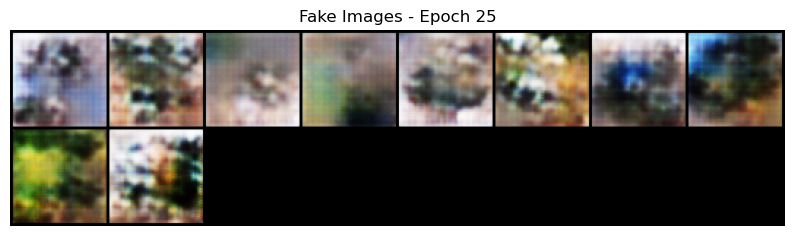

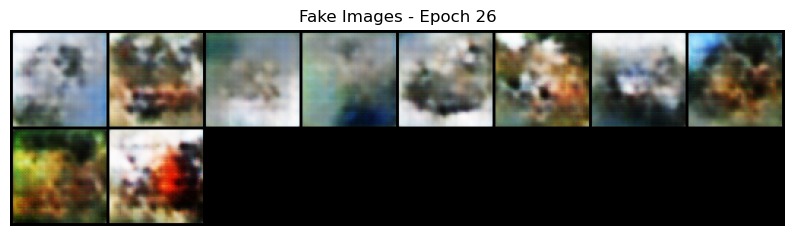

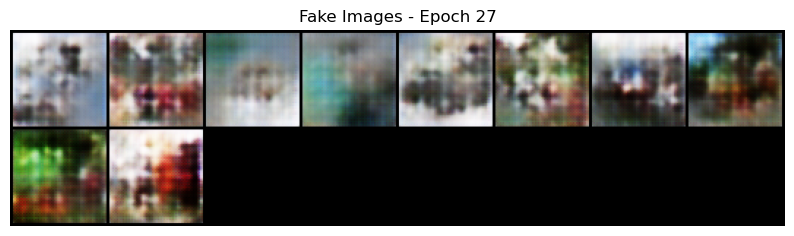

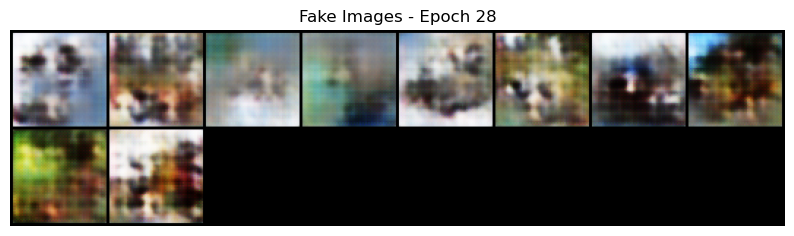

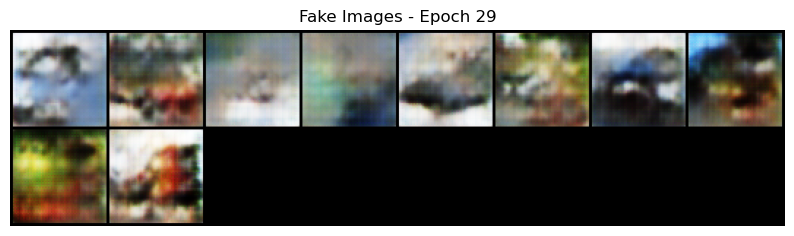

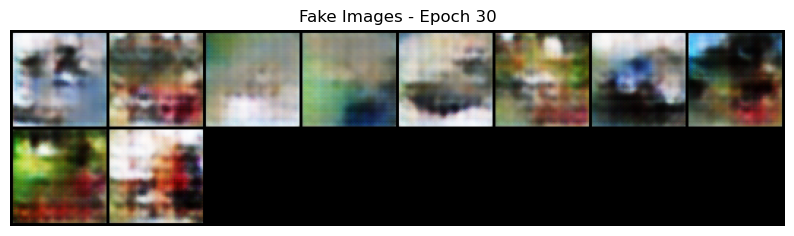

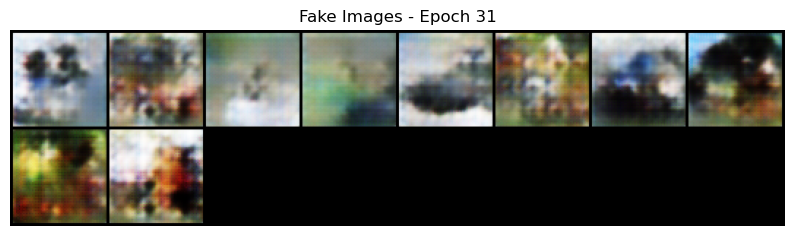

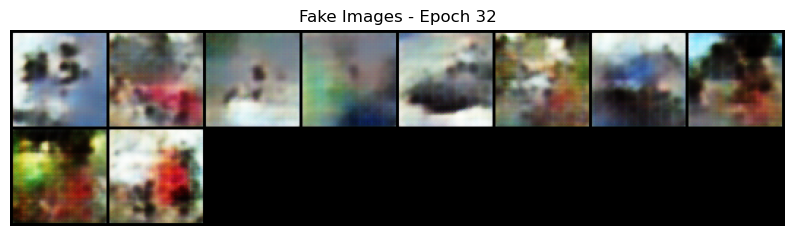

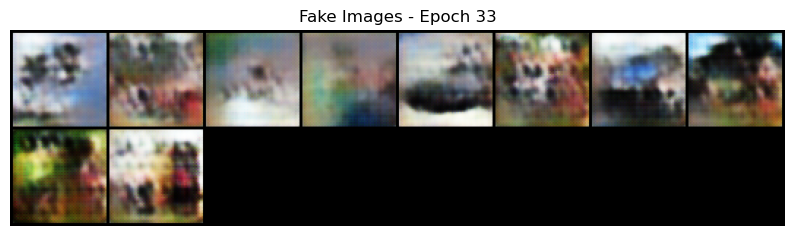

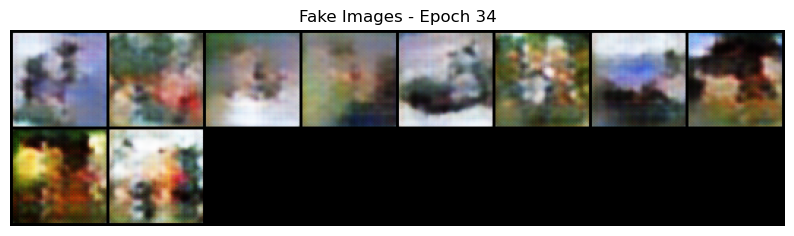

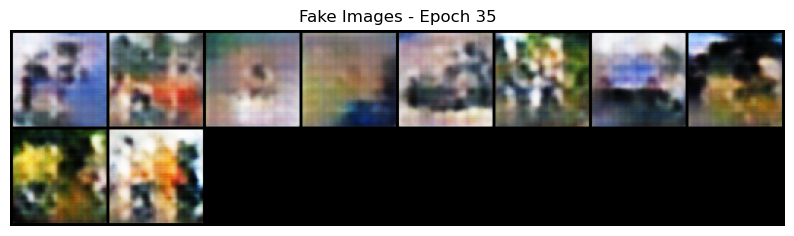

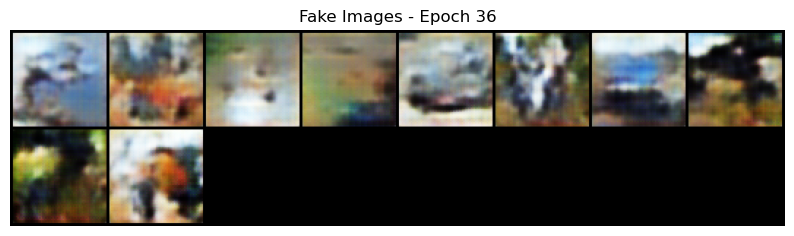

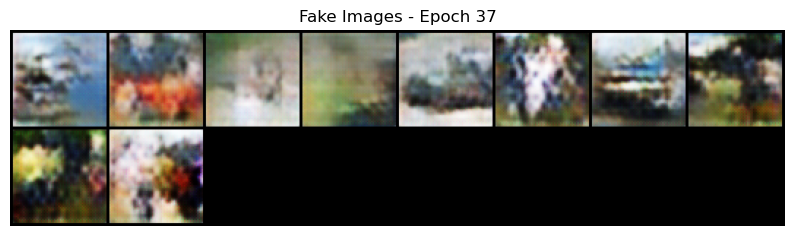

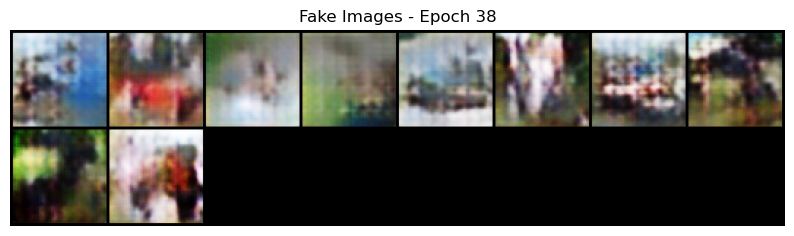

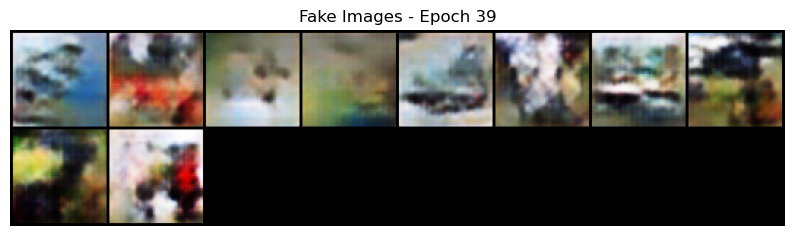

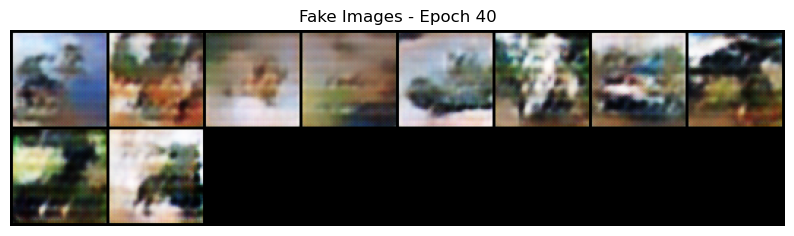

In [26]:
import os
import torchvision.utils as vutils

genet = Generator(noise_dimension, image_channels, generator_features).to(device)
discrim = Discriminator(image_channels, discriminator_features).to(device)
model_weights(genet)
model_weights(discrim)

opt_gen = optim.Adam(genet.parameters(), lr=learning_rate, betas=(0.5,0.999))
opt_disc = optim.Adam(discrim.parameters(), lr=learning_rate, betas=(0.5,0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(10, noise_dimension, 1, 1).to(device)
step = 0
loss_ge = []
loss_de = []
fakeimg_list=[]
img_list=[]

# Create folder if not exists
output_folder = "DCGAN_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        noise = torch.randn(batch_size, noise_dimension, 1, 1).to(device)
        fake = genet(noise)

        disc_real = discrim(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discrim(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discrim.zero_grad()
        loss_de.append(loss_disc.detach().cpu())
        loss_disc.backward()
        opt_disc.step()

        output = discrim(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        loss_ge.append(loss_gen.detach().cpu())
        genet.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = real.detach().cpu()
                fakeimg_list.append(vutils.make_grid(fak, padding=2, normalize=True))
                img_list.append(vutils.make_grid(realI, padding=2, normalize=True))

            step += 1

            # Save fake images to file
            vutils.save_image(fak, f"{output_folder}/fake_images_epoch_{epoch}_batch_{batch_idx}.png", normalize=True)

# Print fake images
for i, fakeimg in enumerate(fakeimg_list):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Fake Images - Epoch {i+1}")
    plt.imshow(np.transpose(fakeimg, (1, 2, 0)))
    plt.show()


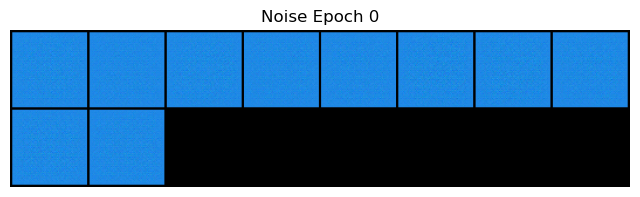

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 0')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list[0:1]]


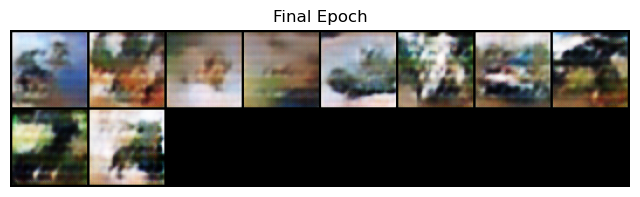

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Final Epoch')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]

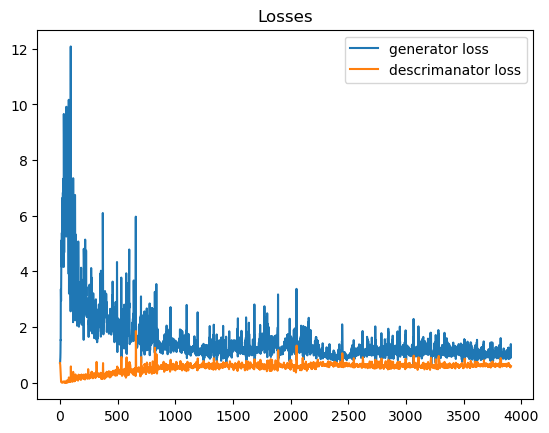

In [30]:
plt.title('Losses')
plt.plot(loss_ge,label = "generator loss")
plt.plot(loss_de,label = "descrimanator loss")
plt.legend()